# First Steps with the DC Motor

##Preliminaries

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [3]:
from ctrl.algo import Proportional, PID, VelocityController, OpenLoop

Substitute `HOST` and `PORT` with the IP address and port of your controller:

In [4]:
from ctrl.client import Controller
HOST, PORT = "192.168.10.110", 9999
controller = Controller(HOST, PORT)

##How does a DC motor respond to a voltage?

Set the controller to be in **open-loop** mode

In [5]:
controller.set_controller1(OpenLoop())

and set the reference at 100% for 5 seconds.

**IMPORTANT**: After executing the following lines the notebook interface will *freeze* for 5 seconds. You will know when you're done when the \* inside `In[*]` changes into a number and the circle on the top of the notebook turns empty again.

In [6]:
with controller:
    controller.set_reference1(100)
    time.sleep(5)

**TASKS**: 
1. Modify the the code and set the reference to levels: 75%, 50%, 25% and 0%
2. Try a negative reference
3. Try a reference greater than 100%

**QUESTIONS**:
1. How does the motor respond to changes in the reference?
2. How does the motor respond to small references? Can you explain it?
3. Which physical quantity does *reference* control?

##Understanding the python interface

### Retrieving and plotting data

The controller runs in the background.

It *starts* as soon as the `with` is executed and *stops* immediatelly when iPython finishes
executing the `with` block.
    
We use `time.sleep(5)` to keep the `with` block running for 5 seconds.

After the block terminates we can use `get_log` to import the data from the controller as a numpy array:

In [7]:
log = controller.get_log()

The array `log` is organized in columns as folows:

time (s) | position (cycles) | reference (%) | control (%)
:----: | :---: | :---: | :---:
0.0  | 0.0 | 100 | 0
0.1  | 0.2 | 90 | 2
... | ... | ... | ...

We will use matplotlib to plot the data:

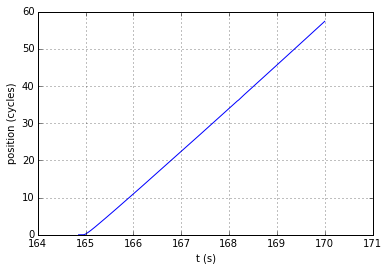

In [8]:
t = log[:,0]
position = log[:,1]
plt.plot(t, position)
# the next lines will make the plot look nicer
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

### Calculating the velocity

Once we have imported the data from the controller box we can easily calculate other quantities using numpy.

For example we can calculate and plot the velocity using the following code:

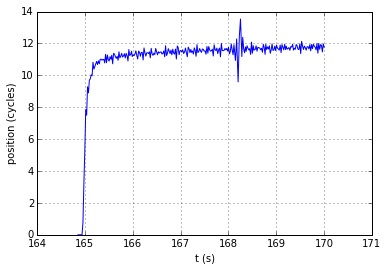

In [9]:
velocity = np.zeros(position.shape)
velocity[1:] = (position[1:] - position[:-1])/(t[1:]-t[:-1])
plt.plot(t, velocity)
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

**TASKS**: 
1. Write python code that resets the controller logger, sets the reference at 50% for 2 seconds then at 0% for 1/2 second and -50% for 2 more seconds then import the data and plot the result using matplotlib

**QUESTION**:
1. How does the motor respond to different constant *reference*?

### Interacting with iPython widgets

We can use iPython widgets to interact with the controller.

For example we can create a slider that will set the reference for us.

In [10]:
from IPython.display import display
from IPython.html import widgets

def set_reference(value):
    controller.set_reference1(value)
    
w = widgets.interactive(set_reference, value=(-100,100))
display(w)

Try moving the slider as you `start` the controller.

In [11]:
controller.reset_logger()
controller.start()
controller.set_reference1(0)

Don't forget to manually `stop` the controller since we are not using a `with` block:

In [12]:
controller.stop()

### Using the potentiometer

We can activate the potentiometer in the controller hardware by setting `reference_mode` to 1 instead of the default 0.

In [ ]:
controller.set_reference1_mode(1)

Then run the controller for 10s while changing the potentiometer in the controller box:

In [ ]:
with controller:
    time.sleep(10)

You have to revert the `reference_mode` to 0 for the command `set_reference` to become active again: 

In [ ]:
controller.set_reference1_mode(0)